# Studying and Testing

## Comparing QIS and Empirical estimator

In [1]:
import numpy as np
import torch

In [3]:
rng = np.random.default_rng(0)
N = 100
A = rng.standard_normal((N,N))
Sigma_true = A @ A.T + 1e-6 *np.eye(N)

In [5]:
rng = np.random.default_rng(0)

def computeFroEmp(Ts):
    frobs = np.zeros_like(Ts, dtype=float)
    for i, T in enumerate(Ts):
        R = rng.multivariate_normal(mean = np.zeros(shape=(N)), cov = Sigma_true, size=(1000, T)).transpose(0,2,1)
        R_centered = R - R.mean(axis=2, keepdims=True)
        Sigma_sample = R_centered @ R_centered.transpose(0,2,1)/(R.shape[-1]-1)
        frob = np.linalg.norm(Sigma_true[None,:,:] - Sigma_sample, axis=(1,2)).mean()
        frobs[i]=frob
    return frobs

In [6]:
Ts = [10, 50, 100, 500, 1000]
frobs = computeFroEmp(Ts)

In [7]:
frobs

array([3355.08458422, 1435.10572508, 1012.33426418,  449.74149864,
        318.03645415])

array([6.71345148, 2.94127175, 2.05643876, 0.90936557, 0.64688036,
       0.29196472, 0.20374291, 0.09137402, 0.06529839])

In [8]:
import matplotlib.pyplot as plt

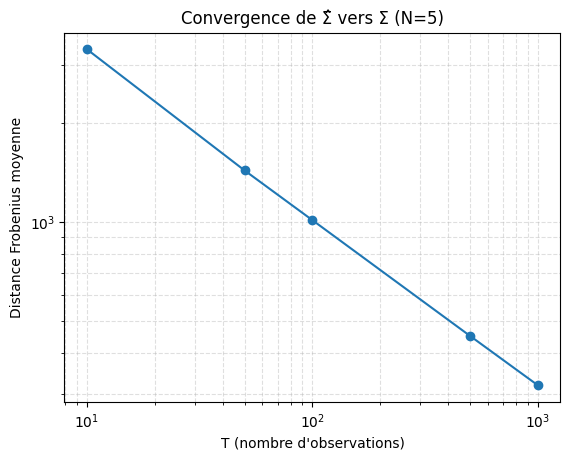

In [9]:
plt.figure()
plt.loglog(Ts, frobs, marker='o')
plt.xlabel("T (nombre d'observations)")
plt.ylabel("Distance Frobenius moyenne")
plt.title("Convergence de Σ̂ vers Σ (N=5)")
plt.grid(True, which="both", ls="--", alpha=0.4)
plt.show()


In [10]:
from estimator.QIS import QIS_batched_numpy

In [ ]:
def computeFroQIS(Ts):
    frobs = np.zeros_like(Ts, dtype=float)
    R = rng.multivariate_normal(mean = np.zeros(shape=(N)), cov = Sigma_true, size=(1000, 1000)).transpose(0,2,1)
    for i,T in enumerate(Ts):
        Sigma_QIS = QIS_batched_numpy(R[:,:,T:])
        frob = np.linalg.norm(Sigma_true[None,:,:] - Sigma_QIS, axis=(1,2)).mean()
        frobs[i] = frob
    return frobs

In [20]:
def computeFroEmp(Ts):
    frobs = np.zeros_like(Ts, dtype=float)
    R = rng.multivariate_normal(mean = np.zeros(shape=(N)), cov = Sigma_true, size=(1000, 1000)).transpose(0,2,1)
    for i,T in enumerate(Ts):
        R_centered = R[:,:,T:] - R[:,:,T:].mean(axis=2, keepdims=True)
        Sigma_sample = R_centered @ R_centered.transpose(0,2,1)/(R[:,:,T:].shape[-1]-1)
        frob = np.linalg.norm(Sigma_true[None,:,:] - Sigma_sample, axis=(1,2)).mean()
        frobs[i] = frob
    return frobs

In [ ]:
Ts = np.int64(np.linspace(0, 998, 100))[::-1]
frobsQIS = computeFroQIS(Ts)

In [21]:
Ts = np.int64(np.linspace(0, 998, 100))[::-1]
frobsEMP = computeFroEmp(Ts)

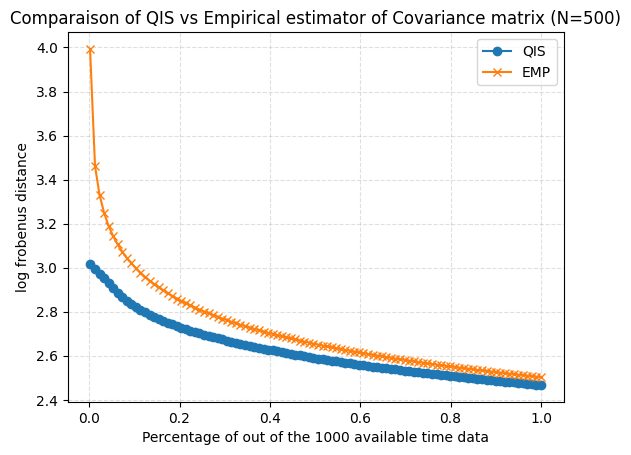

In [43]:
plt.figure()
plt.plot((1000 - Ts)/1000, np.log10(frobs), marker='o', label='QIS')
plt.plot((1000 - Ts)/1000, np.log10(frobsEMP), marker='x', label='EMP')
plt.xlabel("Percentage of out of the 1000 available time data")
plt.ylabel("log frobenus distance")
plt.title("Comparaison of QIS vs Empirical estimator of Covariance matrix (N=500)")
plt.grid(True, which="both", ls="--", alpha=0.4)
plt.legend()
plt.show()


## Study of wishart distribution

In [ ]:
df = np.random.uniform(2 * (5 + 1), 10 * 5)
Sigma_true = torch.distributions.Wishart(
    df=df, covariance_matrix=torch.eye(5)
).sample((2,))*(df - 5 - 1)

Z = torch.randn(2, 10, 5)
L = torch.linalg.cholesky(Sigma_true)
R = L @ Z.transpose(1, 2)  # (B, N, T)

In [40]:
from data.dataloader import make_random_pattern_vecto
from data.dataloader import torch_cov_pairwise

In [28]:
R_hat, _, mask = make_random_pattern_vecto(R, 2)  # (B, N, T), (B, N), (B, N, T)

In [35]:
mask = R_hat.isnan()
true_indice = torch.where(mask)
R_hat

tensor([[[ 4.4157e+00, -1.2745e+01,  2.3322e+00,  1.7946e+01, -8.1209e+00,
          -1.0469e+01,  1.3334e+01, -3.0516e+00,  1.3812e+01, -1.2062e+01],
         [        nan,         nan,  7.9746e+00,  7.8454e+00, -8.4375e+00,
          -1.6510e+00,  3.8622e+00, -5.2992e-03, -8.2007e+00, -3.9072e-01],
         [        nan,         nan,         nan,         nan,         nan,
          -2.6591e+00, -8.9839e+00,  1.7763e+01, -1.1821e+01, -1.0226e+01],
         [        nan,         nan,         nan,         nan,         nan,
           7.0096e+00, -5.8453e+00,  4.1394e+00, -1.3229e+01, -1.1102e+01],
         [        nan,         nan,         nan,         nan,         nan,
          -1.4487e+01, -6.7467e+00, -5.2916e+00, -1.9499e+01,  2.5428e+00]],

        [[-1.4033e+00, -1.2430e+01, -2.2384e+00,  6.6931e+00, -7.9426e+00,
          -2.7157e-01,  6.3339e+00,  5.6473e-01,  4.5155e+00, -2.2718e+00],
         [        nan,         nan,         nan, -3.6496e+01, -1.1889e+01,
          -2.4079

In [30]:
true_indice

(tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 tensor([1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 1, 1, 1, 2, 2, 2, 2,
         3, 3, 3, 3, 3, 4, 4, 4, 4, 4]),
 tensor([0, 1, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 0, 1, 2, 3,
         0, 1, 2, 3, 4, 0, 1, 2, 3, 4]))

In [ ]:
Sigma_hat = torch_cov_pairwise(
    R_hat
)

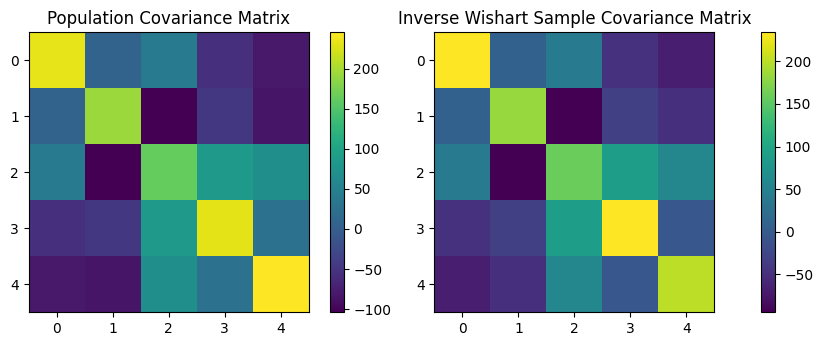

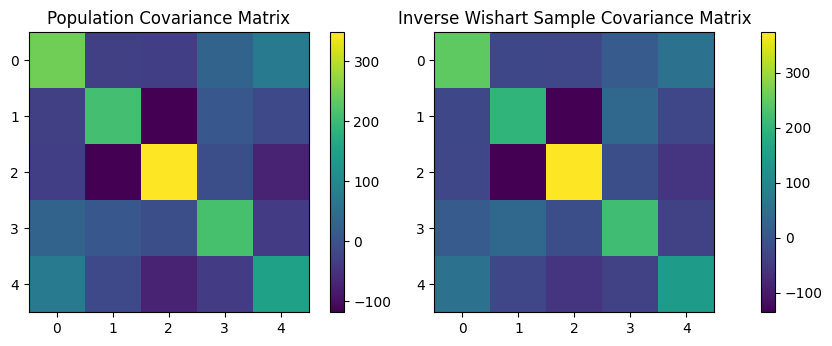

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plt.imshow(Sigma_hat[0], cmap='viridis')
plt.colorbar()
plt.title('Inverse Wishart Sample Covariance Matrix')
plt.subplot(2,2,1)
plt.imshow(np.cov(R[0]), cmap='viridis')
plt.colorbar()
plt.title('Population Covariance Matrix')
plt.show()

plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plt.imshow(Sigma_hat[1], cmap='viridis')
plt.colorbar()
plt.title('Inverse Wishart Sample Covariance Matrix')
plt.subplot(2,2,1)
plt.imshow(np.cov(R[1]), cmap='viridis')
plt.colorbar()
plt.title('Population Covariance Matrix')
plt.show()

In [7]:
eigvals, eigvecs = torch.linalg.eigh(Sigma_hat)

In [8]:
eigvals_desc = torch.flip(eigvals, dims=[1])  # (B, N)
eigvecs_desc = torch.flip(eigvecs, dims=[2])  # (B, N, N)
eigvecs_desc

tensor([[[-0.2673, -0.8238,  0.2016,  0.2885, -0.3551],
         [-0.4742,  0.2027, -0.3234,  0.7345,  0.2999],
         [ 0.5046, -0.3914,  0.1125,  0.1814,  0.7393],
         [ 0.5339, -0.1178, -0.7222,  0.2096, -0.3683],
         [ 0.4050,  0.3365,  0.5662,  0.5481, -0.3189]],

        [[-0.0998,  0.7753,  0.4332, -0.4375,  0.0991],
         [-0.4461, -0.3599,  0.0754, -0.5893, -0.5644],
         [ 0.8739, -0.0542,  0.1560, -0.2304, -0.3948],
         [-0.0973, -0.2508,  0.8649,  0.4158, -0.0817],
         [-0.1334,  0.4511, -0.1849,  0.4852, -0.7135]]])

In [9]:
Tmin = mask.float().argmax(dim=2).unsqueeze(-1)  # (B, N, 1)
Tmax = mask.flip(dims=[2]).float().argmax(dim=2).unsqueeze(-1)  # (B, N, 1)

In [10]:
Tmin.transpose(1,2)

tensor([[[ 0, 15, 18, 26, 32]],

        [[ 0, 10, 15, 23, 42]]])

In [11]:
Tmax.transpose(1,2)

tensor([[[0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 0]]])

In [12]:
eigvecs_desc.transpose(1, 2).pow(2) @ Tmin.float()

tensor([[[20.6162],
         [ 7.3592],
         [25.6153],
         [19.4407],
         [17.9686]],

        [[14.4119],
         [11.3339],
         [19.0639],
         [18.1316],
         [27.0587]]])

[124 177 175  98 117]
19.827932796698683


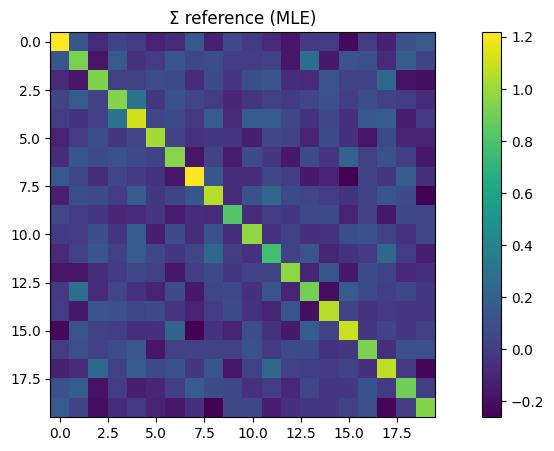

[1.21772793 0.92177596 0.93443857 0.94189391 1.12342308 1.02264928
 0.94724549 1.21114316 1.05742309 0.82365491 0.97959488 0.7687178
 0.96901918 0.90702881 1.05197884 1.10045746 0.92679772 1.0786763
 0.89811247 0.94617396]


In [ ]:
import scipy.stats as st
import matplotlib.pyplot as plt
N = 20
T = 40 # lots of noices if small
df = np.random.randint( 5* (N -1), 10 * N, size=5)  # degrees of freedom for invwishart

mat = st.invwishart.rvs(df=(df[0]), scale=np.eye(N))*(df[0]-N-1)
print(df)
print(np.trace(mat))
plt.figure(figsize=(12,5))
plt.imshow(mat, cmap='viridis')
plt.colorbar(); plt.title('Σ reference (MLE)')
plt.show()

In [14]:
df

array([39, 38, 38, 38, 39])

In [15]:
invwishart_sampler = np.vectorize(lambda x: st.invwishart.rvs(df=x, scale=np.eye(N))*(x-N-1), signature='()->(n,n)')
Sigma_true = invwishart_sampler(df)
Sigma_true = torch.tensor(Sigma_true, dtype=torch.float32)

In [16]:
#Sigma_true = torch.eye(N)
#Sigma_true = Sigma_true.expand(5, N, N).clone()

In [17]:
L = torch.linalg.cholesky(Sigma_true)
Z = torch.randn(5, T, N).transpose(1, 2)
R = L @ Z

In [18]:
# no missing data
Rc = R - R.mean(dim=1, keepdim=True)
cov = Rc @ Rc.transpose(1,2) / (T - 1)
cov.size()

torch.Size([5, 20, 20])

In [19]:
((Sigma_true - cov) ** 2).mean(dim=(1,2)) 

tensor([0.0328, 0.0321, 0.0283, 0.0227, 0.0242])

tensor([0.0100, 0.0100, 0.0113, 0.0118, 0.0095])
vs
tensor([0.0583, 0.0534, 0.0560, 0.0655, 0.0529]) q big N/T

In [20]:
eigs_real, _ = torch.linalg.eigh(Sigma_true)
eigs_approx, _ = torch.linalg.eigh(cov)

In [21]:
((eigs_real - eigs_approx) ** 2).mean(dim=(1)) 

tensor([0.1016, 0.0455, 0.1085, 0.0428, 0.0599])

tensor([0.1857, 0.4791, 0.4030, 0.1478, 0.3203])
vs
tensor([5.8104, 6.8074, 7.2211, 8.1183, 6.0892])

On a test file I am trying to observe when the MLE (without missingness) becomes bad 

In [22]:
from data.real_dataloader import real_data_pipeline

In [23]:
dataset = real_data_pipeline(
    1000,
    date_bounds=('1995-01-01','2015-01-01'),
    n_days_out = T,
    n_days_in = T,
    shift = 0,
    n_stocks = N,
    market_cap_range = (1000, 3000),
    sequential = False,
    return_generator = False,
)

In [24]:
(rin_tf, nan_mask), rout_tf = next(iter(dataset))

In [25]:
rin = torch.from_numpy(rin_tf.numpy())
rout = torch.from_numpy(rin_tf.numpy())

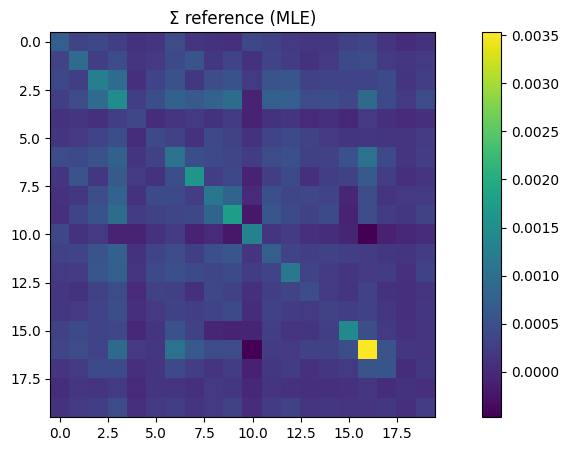

In [28]:
plt.figure(figsize=(12,5))
plt.imshow(rout[3].cov(), cmap='viridis')
plt.colorbar(); plt.title('Σ reference (MLE)')
plt.show()

In [45]:
mean = 0
for i in range(500):
    S = scale=np.eye(N)
    nu_hat = np.trace(np.linalg.solve(rout[0].cov(), S)) / N
    mean += nu_hat/500

In [46]:
mean

np.float64(4425.433867610068)

## Experience on relation q vs loss on covariance matrix

Compute loss surface of $\Sigma_{true}(N,T)$ vs $\Sigma_{cov}(N,T)$

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import torch

In [17]:
def loss_function_corr(Corr_oos, Corr_pred, T):
    B, N, _ = Corr_oos.shape

    # Matrix difference
    Delta = Corr_pred - Corr_oos  # (B, N, N)

    ## CB: It seems more efficient to compute the Frobenius norm via squaring element-wise and summing.
    # Square of the matrix (Delta^2 = Delta @ Delta) Symetric matrix so we don't need to transpose !
    Delta2 = Delta @ Delta  # (B, N, N)

    # Trace of Delta2 = sum of diagonal
    trace_vals = Delta2.diagonal(dim1=1, dim2=2).sum(dim=1)  # (B,)

    # Normalized Frobenius estimation error (Potters-Bouchaud)
    loss_cov = torch.sqrt(trace_vals) * T / N**2  # (B,)

    return loss_cov.mean()  # scalar

In [18]:
Ns = np.linspace(100, 600, 80, dtype=int)
Ts = np.linspace(20, 70, 40, dtype=int)
loss = []
for N in Ns: 
    for T in Ts:
        df = np.random.randint(5 * N, 10 * N)  # degrees of freedom for invwishart
        Sigma_true = st.invwishart.rvs(df=df, scale=np.eye(N))*(df-N-1)
        Z = np.random.standard_normal((N, T))
        L = np.linalg.cholesky(Sigma_true)
        R = L @ Z
        Sigma_emp = np.cov(R)
        eps = 1e-12
        std = np.sqrt(np.diag(Sigma_emp))
        corr1 = Sigma_emp / (np.outer(std, std) + eps)
        std2 = np.sqrt(np.diag(Sigma_true))
        corr2 = Sigma_true / (np.outer(std2, std2)+ eps)
        loss.append(loss_function_corr(torch.from_numpy(corr1[None,:,:]), torch.from_numpy(corr2[None,:,:]), T))

In [19]:
# meshing
loss_grid = np.array(loss).reshape(len(np.array(Ns)), len(np.array(Ts)))
N_mesh, T_mesh = np.meshgrid(np.array(Ns), np.array(Ts), indexing='ij')

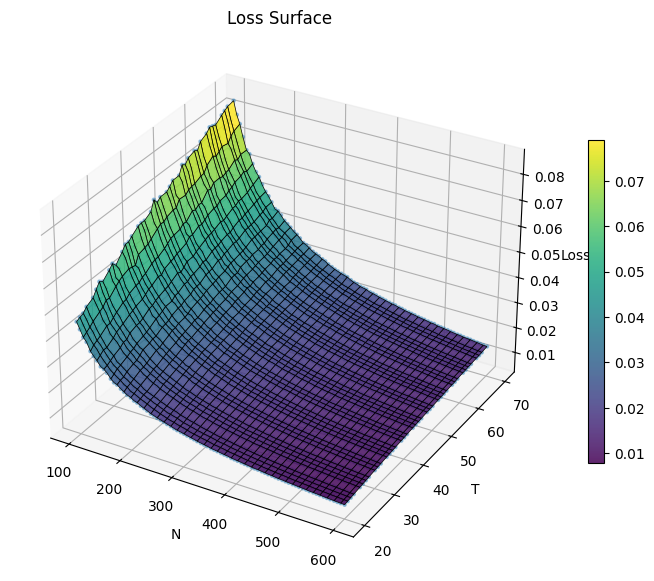

In [20]:
# plot
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')


surf = ax.scatter(
    N_mesh, T_mesh, loss_grid,
    s=5, alpha=0.4, label="data"
)
surf = ax.plot_surface(N_mesh, T_mesh, loss_grid,
                       cmap='viridis',
                       edgecolor='k',
                       linewidth=0.5,
                       alpha=0.85)

ax.set_xlabel("N")
ax.set_ylabel("T")
ax.set_zlabel("Loss")
ax.set_title("Loss Surface")

fig.colorbar(surf, shrink=0.6)
plt.show()

In [79]:
X = np.column_stack([
    N_mesh.ravel(),
    T_mesh.ravel(),
    loss_grid.ravel()
])
mu = X.mean(axis=0)
sigma = X.std(axis=0)

X_standard = (X - mu)/ sigma

In [80]:
Sig = X_standard.T @ X_standard / X.shape[0]
eigV, U = np.linalg.eigh(Sig)
u3, u2, u1 = U[:, 0], U[:, 1], U[:, 2]

In [81]:
a = np.linspace(-3, 3, 40)
b = np.linspace(-3, 3, 40)
A, B = np.meshgrid(a, b)

In [84]:
Plane_std = (
    + A[..., None] * u1
    + B[..., None] * u2
)

Plane = Plane_std * sigma + mu

N_plane    = Plane[..., 0]
T_plane    = Plane[..., 1]
Loss_plane = Plane[..., 2]

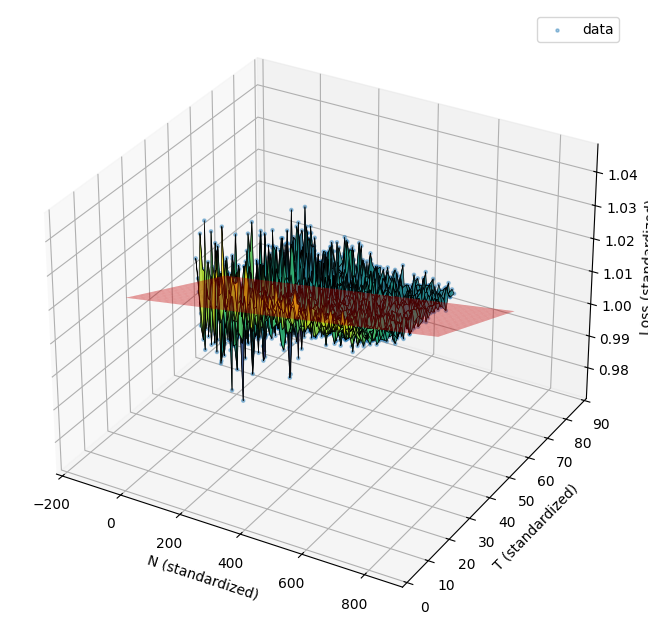

In [102]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(projection="3d")

# scatter the data
ax.scatter(
    X[:, 0], X[:, 1], X[:, 2],
    s=5, alpha=0.4, label="data"
)


# plot PCA plane
ax.plot_surface(
    N_plane, T_plane, Loss_plane,
    color="red", alpha=0.4, linewidth=0
)
surf = ax.plot_surface(N_mesh, T_mesh, loss_grid,
                       cmap='viridis',
                       edgecolor='k',
                       linewidth=0.5,
                       alpha=0.85)
ax.set_xlabel("N (standardized)")
ax.set_ylabel("T (standardized)")
ax.set_zlabel("Loss (standardized)")
ax.legend()
plt.show()


2nd experience*

In [117]:
Ns_2 = np.linspace(100, 600, 40, dtype=int)
Ts_2 = np.linspace(20, 70, 20, dtype=int)
loss_2 = []

In [118]:
for N in Ns_2: 
    for T in Ts_2:
        df = np.random.randint(5 * N, 10 * N)  # degrees of freedom for invwishart
        Sigma_true = st.invwishart.rvs(df=df, scale=np.eye(N))*(df-N-1)
        Z = np.random.standard_normal((N, T))
        L = np.linalg.cholesky(Sigma_true)
        R = L @ Z
        Sigma_emp = np.cov(R)
        loss_2.append(np.linalg.norm(Sigma_true - Sigma_emp, 'fro')*T/N**2)


In [119]:
# meshing
loss_grid_2 = np.array(loss_2).reshape(len(np.array(Ns_2)), len(np.array(Ts_2)))
N_mesh_2, T_mesh_2 = np.meshgrid(np.array(Ns_2), np.array(Ts_2), indexing='ij')

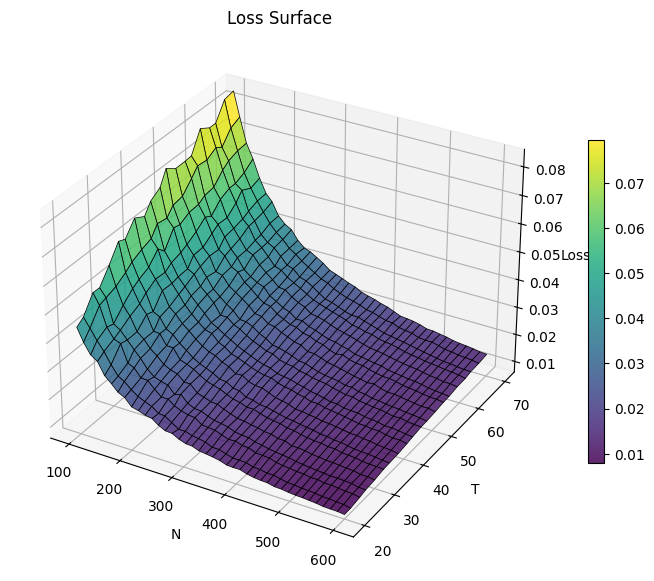

In [120]:
# plot
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(N_mesh_2, T_mesh_2, loss_grid_2,
                       cmap='viridis',
                       edgecolor='k',
                       linewidth=0.5,
                       alpha=0.85)

ax.set_xlabel("N")
ax.set_ylabel("T")
ax.set_zlabel("Loss")
ax.set_title("Loss Surface")

fig.colorbar(surf, shrink=0.6)
plt.show()

That loss is logic : small N (= small amount of sample) mean big loss, and when T increases (amount of features increases) the loss increases => OK